# Importing necessary libs and data

In [1]:
import gc
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchvision.transforms as T
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
#from kaggle.api.kaggle_api_extended import KaggleApi
from torchvision.datasets import ImageFolder
from zipfile import ZipFile
from PIL import Image
from tqdm import tqdm

In [ ]:
with ZipFile("archive.zip") as f:
    f.extractall()

# Important variables

In [2]:
# Folder with resized paintings
img_path = "/home/user/resized/"

# Batch size
batch_size = 16

#Learning rate
lr = 1e-4

# Number of channels
nc = 3

# Size of feature map in generator
ngf = 32

# Image size (length and width)
ims = 200

# Size of latent vector for generator
nz = 100

# True_label
true_label = 1

# Fake_label 
fake_label = 0

beta1 = 0.5

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
torch.cuda.get_device_name()

'Tesla V100-SXM2-32GB'

# DataLoader creation

In [4]:
transform = T.Compose([
    T.Resize((ims, ims)),
    T.ToTensor(),

])

paintings = ImageFolder(img_path, transform=transform)
paintings = torch.utils.data.Subset(paintings, np.random.choice(len(paintings), 4000, replace=False))

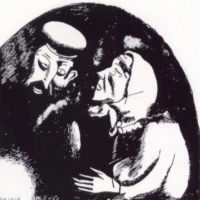

In [5]:
img = T.functional.to_pil_image(paintings[3500][0])
img

In [6]:
dataloader = DataLoader(paintings, batch_size, drop_last=True, shuffle=True)

# Model architecture

### Discriminator

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(nc, 32, kernel_size=(7, 7), padding=(1, 1), stride=(2, 2), dilation=(1, 1), bias=False), 
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1), dilation=(1, 1), bias=False),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
        )


        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=(6, 6), stride=(2, 2), padding=(1, 1), dilation=(1, 1), bias=False),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, stride=(4, 4), kernel_size=(5, 5), bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=1, stride=7, bias=False),
            nn.Sigmoid() # [batch_size, 1, 1, 1]
        )


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(batch_size, -1) # [batch_size, 1]

        return x

In [8]:
s = next(iter(dataloader))
d = Discriminator()
d(s[0]).shape

torch.Size([16, 1])

### Generator

In [16]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            nn.ConvTranspose2d( nz, ngf * 16, kernel_size=(7, 7), stride=(1, 1), padding=(0, 0), bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 16, ngf * 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 8, ngf * 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=(6, 6), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf * 4, ngf * 2, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf * 2, ngf, kernel_size=(6, 6), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            nn.Dropout(),

            nn.ConvTranspose2d( ngf, nc, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.Tanh()

        )


    def forward(self, x):
        x = self.main(x) # [batch_size, 3, 400, 400]

        return x

# Model training

In [17]:
def weight_init(m):
    """ Accepts the model and initialize weights for Conv. and Batchnorm layers."""
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [18]:
def train(d, g, dopt, gopt, dataloader, criterion, batch_size, epochs) -> tuple:
    fixed_noise = torch.randn(3, nz, 1, 1, device=device)
    img_list = []
    d_losses = []
    g_losses = []

    for epoch in range(1, epochs+1):
        print(f"======= Epoch {epoch} =======")

        for i, (img_batch, _) in enumerate(dataloader):
            img_batch = img_batch.to(device)

            d.zero_grad()

            real_cpu = img_batch.to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), true_label, dtype=torch.float, device=device)

            output = d(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            # Generate fake image batch with G
            fake = g(noise)
            label.fill_(fake_label)

            output = d(fake.detach()).view(-1)

            errD_fake = criterion(output, label)

            errD_fake.backward()
            D_G_z1 = output.mean().item()

            errD = errD_real + errD_fake

            dopt.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            g.zero_grad()
            label.fill_(true_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = d(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            gopt.step()

        
            g_losses.append(errG)
            d_losses.append(errD)

            if i % 67 == 0:
                print(f"Batch {i}; LossD: {errD.item()}; LossG: {errG.item()}")


        with torch.no_grad():
            imgs = g(fixed_noise).detach().cpu()
            img_list.append(imgs)     

    torch.save(g.state_dict(), "generator_l%.4f.pth" % g_losses[-1])
    torch.save(d.state_dict(), "discriminator_l%.4f.pth" % d_losses[-1])

    return img_list, d_losses, g_losses

In [21]:
g = Generator().to(device)
d = Discriminator().to(device)

g.apply(weight_init)
d.apply(weight_init)

dopt = optim.Adam(d.parameters(), lr=lr, betas=(beta1, 0.999))
gopt = optim.Adam(g.parameters(), lr=lr, betas=(beta1, 0.999))

criterion = nn.BCELoss()

In [22]:
torch.cuda.empty_cache()
gc.collect()

8

In [23]:
img_list, d_losses, g_losses = train(d, g, dopt, gopt, dataloader, criterion, batch_size, epochs=10)

======= Epoch 1 =======
Batch 0; LossD: 1.4460501670837402; LossG: 1.0104234218597412
Batch 67; LossD: 0.5009045600891113; LossG: 2.1812362670898438
Batch 134; LossD: 0.6865415573120117; LossG: 3.310420036315918
Batch 201; LossD: 0.15489467978477478; LossG: 3.4511539936065674
======= Epoch 2 =======
Batch 0; LossD: 0.18361498415470123; LossG: 3.2980294227600098
Batch 67; LossD: 1.112511396408081; LossG: 1.8980507850646973
Batch 134; LossD: 0.08636699616909027; LossG: 3.930964469909668
Batch 201; LossD: 0.45163142681121826; LossG: 3.4480512142181396
======= Epoch 3 =======
Batch 0; LossD: 0.34801989793777466; LossG: 2.431058645248413
Batch 67; LossD: 0.47677019238471985; LossG: 2.76595401763916
Batch 134; LossD: 0.3172513246536255; LossG: 2.5818586349487305
Batch 201; LossD: 0.35112836956977844; LossG: 2.869961738586426
======= Epoch 4 =======
Batch 0; LossD: 0.17312052845954895; LossG: 3.5529325008392334
Batch 67; LossD: 0.36023539304733276; LossG: 2.7173261642456055
Batch 134; LossD: 

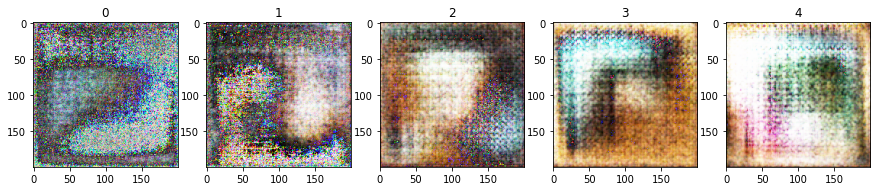

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=len(img_list), figsize=(15, 8))
for i in range(len(img_list)):
    ax[i].set_title(i)
    ax[i].imshow(T.functional.to_pil_image(img_list[i][0]))
        
plt.show()

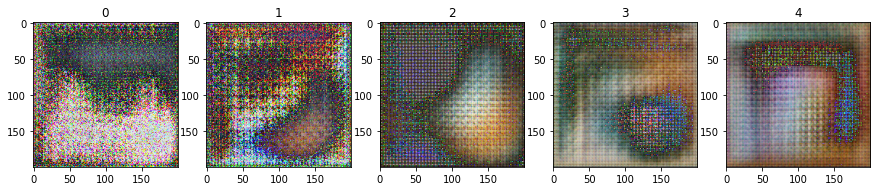

In [15]:
# Generator without dropout and batch_size=32 epochs=5
fig, ax = plt.subplots(nrows=1, ncols=len(img_list), figsize=(15, 8))
for i in range(len(img_list)):
    ax[i].set_title(i)
    ax[i].imshow(T.functional.to_pil_image(img_list[i][0]))
        
plt.show()

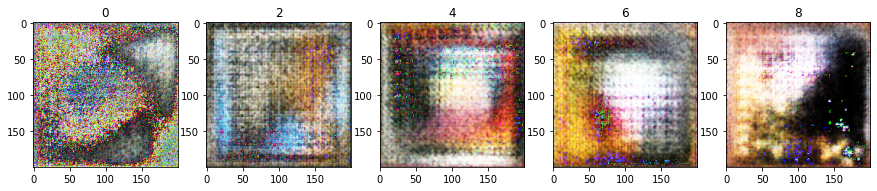

In [50]:
# Generator with dropout and batch_size=32 epochs=10
fig, ax = plt.subplots(nrows=1, ncols=len(pics), figsize=(15, 8))
for i in range(len(pics)):
    
    ax[i].set_title(i*2)
    ax[i].imshow(T.functional.to_pil_image(pics[i][0]))
        
plt.show()

In [30]:
freq = 50

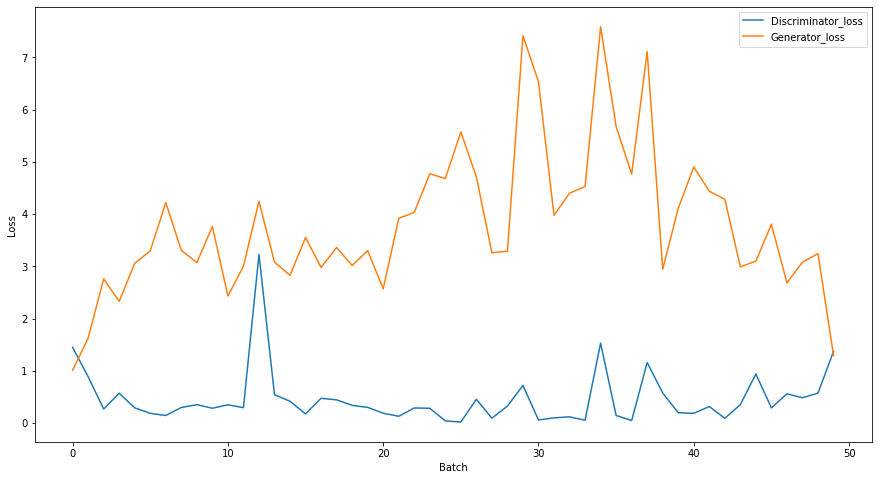

In [31]:
plt.figure(figsize=(15, 8))
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(range(len(d_losses[::freq])), d_losses[::freq], label="Discriminator_loss")
plt.plot(range(len(g_losses[::freq])), g_losses[::freq], label="Generator_loss")
plt.legend()
plt.show()